This lab on Support Vector Machines is a Python adaptation of p. 359-366 of "Introduction to Statistical
Learning with Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. Based on  the adaptation by J. Warmenhoven, updated by R. Jordan Crouser at Smith College for SDS293: Machine
Learning (Spring 2016).

In [150]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline


# We'll define a function to draw a nice plot of an SVM
def plot_svc(svc, X, y, h=0.02, pad=0.25):
    x_min, x_max = X[:, 0].min()-pad, X[:, 0].max()+pad
    y_min, y_max = X[:, 1].min()-pad, X[:, 1].max()+pad
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.2)

    plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=mpl.cm.Paired, alpha=0.7)
    
    # Support vectors indicated in plot by  + _ x ... depending on the class
    
    markers = ''.join(marker*size for size, marker in zip(svc.n_support_, '+_x1234'))
    sv = svc.support_vectors_
    start = 0
    for size, marker in zip(svc.n_support_, '+_x1234'):
        plt.scatter(*sv[start:start+size].T, c='k', marker=marker, s=70, linewidths=2, alpha=0.5)
        start = start+size
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()
    print('Number of support vectors: ', svc.support_.size)

# Support Vector Machines

In this lab, we'll use the `SVC` object from the `sklearn.svm`  module to demonstrate the support vector classifier and the SVM:

In [81]:
from sklearn.svm import SVC

# Support Vector Classifier

The `SVC()` function can be used to fit a
support vector classifier when the argument `kernel="linear"` is used. This
function uses a slightly different formulation of the equations we saw in lecture to build the
support vector classifier. The `C` argument allows us to specify the cost of
a violation to the margin. When the `C` argument is **small**, then the margins
will be wide and many support vectors will be on the margin or will
violate the margin. When the `C` argument is large, then the margins will
be narrow and there will be few support vectors on the margin or violating
the margin.

We can use the `SVC()` function to fit the support vector classifier for a
given value of the `cost` parameter. Here we demonstrate the use of this
function on a two-dimensional example so that we can plot the resulting
decision boundary. Let's start by generating a set of observations, which belong
to two classes:

In [342]:
# Generating random data: 20 observations of 2 features and divide into two classes.
np.random.seed(5)
X = np.random.randn(20,2)
y = np.repeat([1,-1], 10)

X[y == -1] = X[y == -1]+1

Let's plot the data to see whether the classes are linearly separable:

Text(0, 0.5, 'X2')

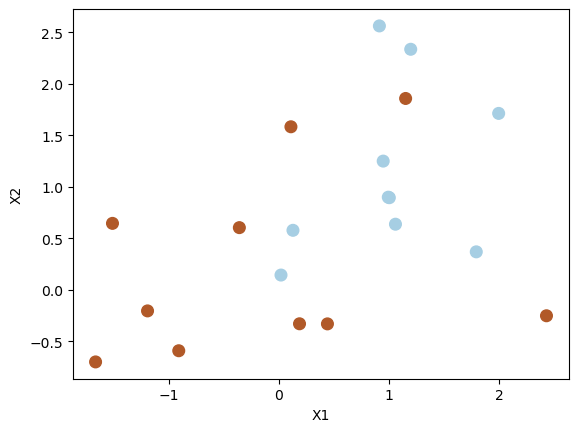

In [343]:
plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=mpl.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2')

## The support machine objective

In this toy example, there are 3 parameters $\beta_0, \beta_1, \beta_2$ and the goal is to find
$$
    \arg\min_{\beta_0,\beta_1,\beta_2} \frac12(\beta_1^2+\beta_{2}^2) +C \sum_{i} (1-y_i(x_{i,1}\beta_1-x_{i,2}\beta_2-\beta_0))_{+} 
$$
For a given $\beta_1,\beta_2$ 
$\beta_0$ is any point in the interval $[z^*_{k},z_{k+1}^*]$, where $k$ is the number of positive examples and $z$ is the ordered sample of $y_i-x_{i,1}\beta_1-x_{i,2}\beta_2$. In our setting $k=10$. 

In [359]:
def Beta0(X, y, beta):
    z = (y - beta@X.T)
    z.sort(axis=-1)
    k = (y+1).sum()//2
    return (z[:,k]+z[:,k+1])/2

def penalized_loss(C, X, y, beta):
    beta0 = Beta0(X, y, beta)
    return (1-y*(beta@X.T+beta0[:,None])).clip(0).sum(axis=-1)*C+(beta**2).sum(axis=-1)/2

def plot_loss(C, X, y, limit=(-10,10), h=0.2):
    b1, b2 = np.meshgrid(np.arange(*limit, h), np.arange(*limit, h))
    beta = np.stack((b1,b2), axis=-1)
    z = penalized_loss(C, X, y, beta.reshape(-1,2)).reshape(beta.shape[:2])
    plt.contourf(b1, b2, np.log(z), alpha=0.2)
    

    
    

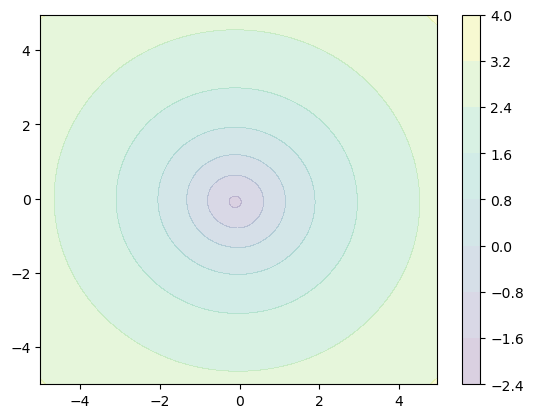

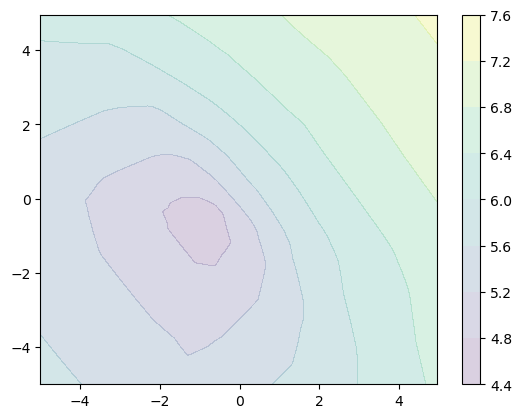

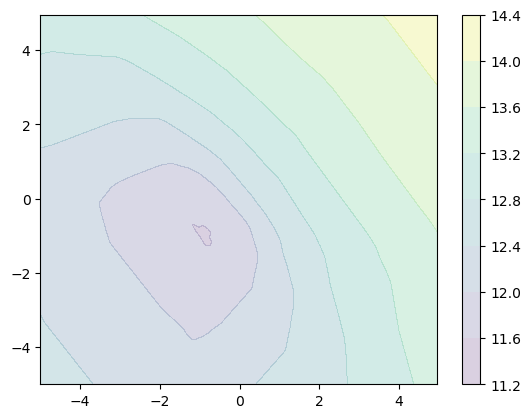

In [364]:
limit = (-5,5)
h = 0.05
plot_loss(0.01, X, y, limit, h)
plt.colorbar()
plt.show()

plot_loss(10, X, y, limit, h)
plt.colorbar()
plt.show()

plot_loss(10000, X, y, limit, h)
plt.colorbar()
plt.show()

Nope; not linear. Next, we fit the support vector classifier:

In [365]:
svc = SVC(C=1, kernel='linear')
svc.fit(X, y)

SVC(C=1, kernel='linear')

We can now plot the support vector classifier by calling the `plot_svc()` function on the output of the call to `SVC()`, as well as the data used in the call to `SVC()`:

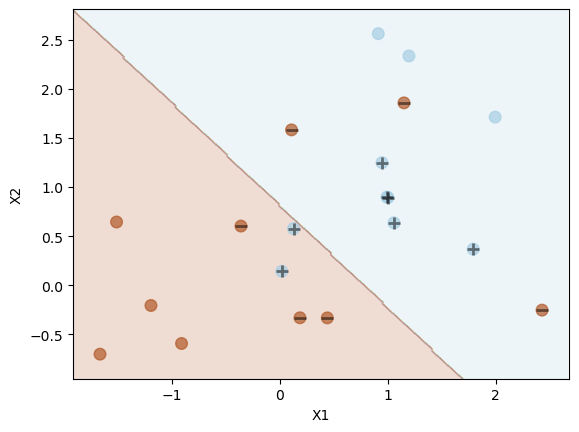

Number of support vectors:  13


In [366]:
plot_svc(svc, X, y)

The region of feature space that will be assigned to the −1 class is shown in
light blue, and the region that will be assigned to the +1 class is shown in
brown. The decision boundary between the two classes is linear (because we
used the argument `kernel="linear"`.

The support vectors are plotted with crosses
and the remaining observations are plotted as circles; we see here that there
are 13 support vectors. We can determine their identities as follows:

In [50]:
svc.support_

array([10, 11, 13, 14, 15, 16, 17,  0,  1,  2,  4,  6,  8], dtype=int32)

What if we instead used a smaller value of the `cost` parameter?

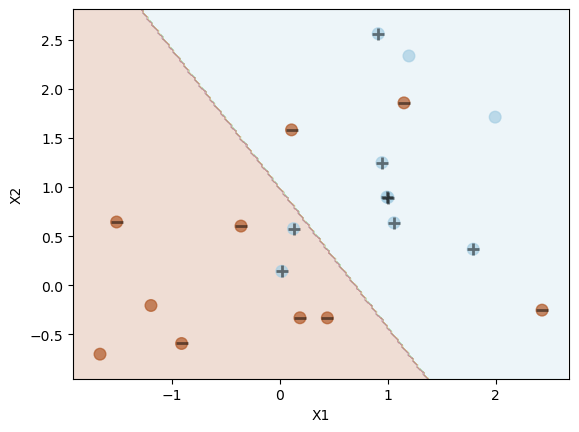

Number of support vectors:  16


In [367]:
svc2 = SVC(C=0.1, kernel='linear')
svc2.fit(X, y)
plot_svc(svc2, X, y)

Now that a smaller value of the `C` parameter is being used, we obtain a
larger number of support vectors, because the margin is now **wider**.

The `sklearn.model_selection` module includes a a function `GridSearchCV()` to perform cross-validation. In order to use this function, we pass in relevant information about the set of models that are under consideration. The
following command indicates that we want perform 10-fold cross-validation to compare SVMs with a linear
kernel, using a range of values of the cost parameter:

In [368]:
from sklearn.model_selection import GridSearchCV

# Select the optimal C parameter by cross-validation
tuned_parameters = [
    {
        'C': [0.001, 0.01, 0.1, 1, 5, 10, 100]
    }
]

clf = GridSearchCV(
    SVC(kernel='linear'), 
    param_grid=tuned_parameters, 
    cv=5, 
    scoring='accuracy'
)

clf.fit(X, y)

GridSearchCV(cv=5, estimator=SVC(kernel='linear'),
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 5, 10, 100]}],
             scoring='accuracy')

We can easily access the cross-validation errors for each of these models:

In [369]:
clf.cv_results_

{'mean_fit_time': array([0.00051475, 0.00040402, 0.000353  , 0.00073695, 0.0008234 ,
        0.00063314, 0.000774  ]),
 'std_fit_time': array([2.48199902e-04, 9.96286857e-05, 8.22376981e-05, 1.38702659e-04,
        4.92752085e-05, 1.52480758e-04, 1.15099601e-04]),
 'mean_score_time': array([0.0003489 , 0.00023432, 0.00020742, 0.00042367, 0.00049791,
        0.00034451, 0.00040812]),
 'std_score_time': array([2.13241801e-04, 6.30791582e-05, 1.36487088e-05, 1.16419770e-04,
        3.28846901e-05, 7.45130345e-05, 4.71595083e-05]),
 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 5, 10, 100],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 5},
  {'C': 10},
  {'C': 100}],
 'split0_test_score': array([0.5 , 0.5 , 0.5 , 0.  , 0.25, 0.25, 0.25]),
 'split1_test_score': array([0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75]),
 'split2_test_score': arra

The `GridSearchCV()` estimator stores the best parameters obtained, which can be accessed as
follows:

In [370]:
print(f'best paramterers: {clf.best_params_}, number of support vectors {len(clf.best_estimator_.support_)}')

best paramterers: {'C': 0.001}, number of support vectors 20


`c=0.001` is best according to `GridSearchCV`. 

As usual, the `predict()` function can be used to predict the class label on a set of
test observations, at any given value of the cost parameter. Let's
generate a test data set:

In [371]:
np.random.seed(1)
X_test = np.random.randn(20,2)
y_test = np.random.choice([-1,1], 20)
X_test[y_test == 1] = X_test[y_test == 1]-1

Now we predict the class labels of these test observations. Here we use the
best model obtained through cross-validation in order to make predictions:

In [372]:
def make_cm(model, X, y):
    y_pred = model.predict(X)
    cm = pd.DataFrame(confusion_matrix(y_pred=y_pred, y_true=y), 
                      columns=model.classes_, index=model.classes_)
    cm.index.name = 'True'
    cm.columns.name = 'Predicted'
    return cm
    

In [374]:
svc2 = SVC(C=0.001, kernel='linear')
svc2.fit(X, y)
print(make_cm(svc2, X_test, y_test))


Predicted  -1   1
True             
-1          2   6
 1          0  12


With this value of `C`, 14 of the test observations are correctly
classified.

Now consider a situation in which the two classes are linearly separable.
Then we can find a separating hyperplane using the `svm()` function. First we'll give our simulated data a little nudge so that they are linearly separable:

Text(0, 0.5, 'X2')

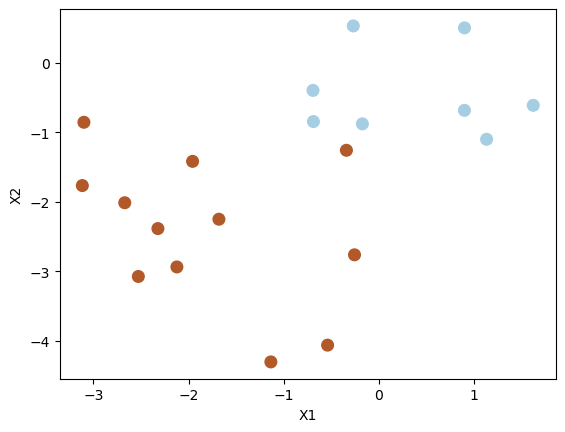

In [375]:
X_test[y_test == 1] = X_test[y_test == 1] -1
plt.scatter(X_test[:,0], X_test[:,1], s=70, c=y_test, cmap=mpl.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2')

Now the observations are **just barely linearly** separable. We fit the support
vector classifier and plot the resulting hyperplane, using a very large value
of `cost` so that no observations are misclassified.

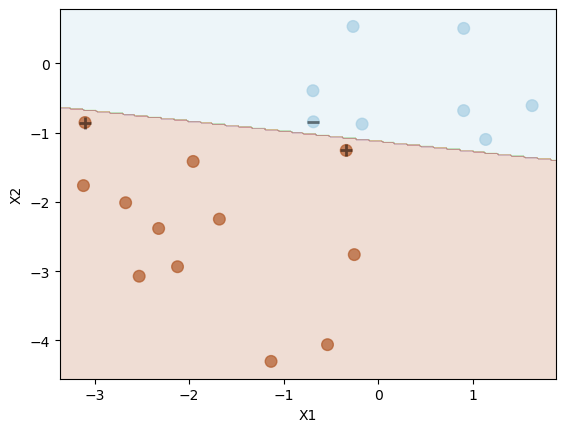

Number of support vectors:  3


In [98]:
svc3 = SVC(C=1e5, kernel='linear')
svc3.fit(X_test, y_test)
plot_svc(svc3, X_test, y_test)

No training errors were made and only three support vectors were used.
However, we can see from the figure that the margin is very narrow (because
the observations that are **not** support vectors, indicated as circles, are very close to the decision boundary). It seems likely that this model will perform
poorly on test data. Let's try a smaller value of `cost`:

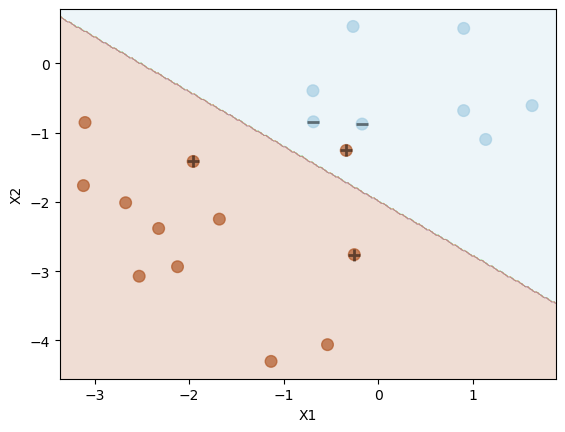

Number of support vectors:  5


In [99]:
svc4 = SVC(C=1, kernel='linear')
svc4.fit(X_test, y_test)
plot_svc(svc4, X_test, y_test)

Using `cost`, we misclassify a training observation, but we also obtain
a much wider margin and make use of five support vectors. It seems
likely that this model will perform better on test data than the model with
`cost=1e5`.

# 9.6.2 Support Vector Machine

In order to fit an SVM using a **non-linear kernel**, we once again use the `SVC()`
function. However, now we use a different value of the parameter kernel.
To fit an SVM with a polynomial kernel we use `kernel="poly"`, and
to fit an SVM with a radial kernel we use `kernel="rbf"`. In the former
case we also use the `degree` argument to specify a degree for the polynomial
kernel, and in the latter case we use `gamma` to specify a
value of $\gamma$ for the radial basis kernel.

Let's generate some data with a non-linear class boundary:

In [100]:
from sklearn.model_selection import train_test_split

np.random.seed(8)
X = np.random.randn(200, 2)
X[:100] = X[:100] + 2
X[101:150] = X[101:150] - 2
y = np.concatenate([np.repeat(-1, 150), np.repeat(1,50)])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=2)


Text(0, 0.5, 'X2')

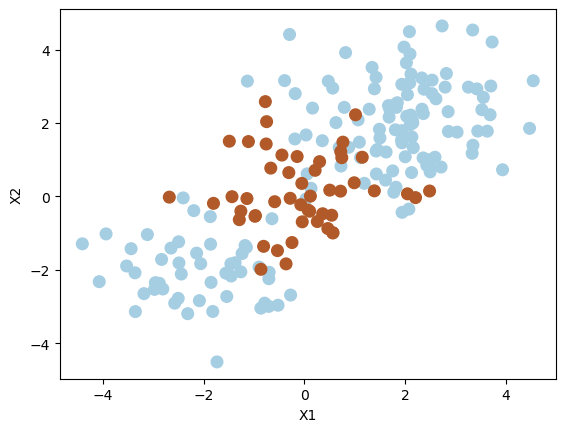

In [101]:

plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=mpl.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2')

See how one class is kind of stuck in the middle of another class? This suggests that we might want to use a **radial kernel** in our SVM. Now let's fit
the training data using the `SVC()`function with a radial kernel and $\gamma = 1$:

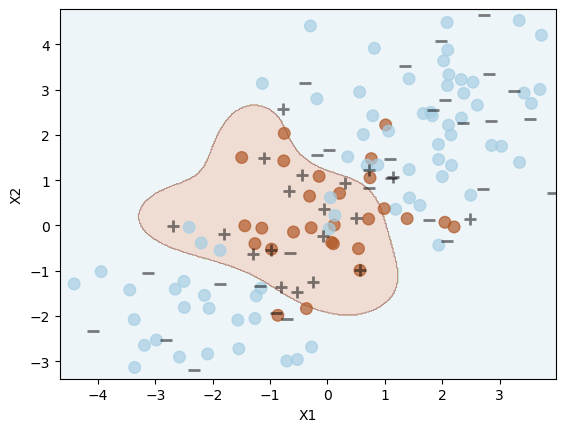

Number of support vectors:  51


In [102]:
svm = SVC(C=1.0, kernel='rbf', gamma=1)
svm.fit(X_train, y_train)
plot_svc(svm, X_test, y_test)

Not too shabby! The plot shows that the resulting SVM has a decidedly non-linear
boundary. We can see from the figure that there are a fair number of training errors
in this SVM fit. If we increase the value of cost, we can reduce the number
of training errors:

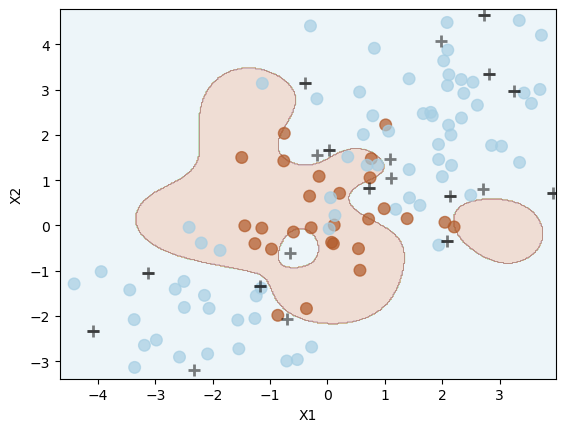

Number of support vectors:  36


In [148]:
# Increasing C parameter, allowing more flexibility
svm2 = SVC(C=100, kernel='rbf', gamma=1.0)
svm2.fit(X_train, y_train)
plot_svc(svm2, X_test, y_test)

However, this comes at the price of a more irregular decision boundary that seems to be at risk of overfitting the data. We can perform cross-validation using `GridSearchCV()` to select the best choice of
$\gamma$ and cost for an SVM with a radial kernel:

In [104]:
tuned_parameters = [
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'gamma': [0.5, 1, 2, 3, 4]        
    }
]
clf = GridSearchCV(
    SVC(kernel='rbf'), 
    param_grid=tuned_parameters, 
    cv=10,
    refit=True,
    scoring='accuracy'
)

clf.fit(X_train, y_train)
clf.best_params_

{'C': 10, 'gamma': 0.5}

Therefore, the best choice of parameters involves `cost=1` and `gamma=0.5`. We
can plot the resulting fit using the `plot_svc()` function, and view the test set predictions for this model by applying the `predict()` function to the test data:

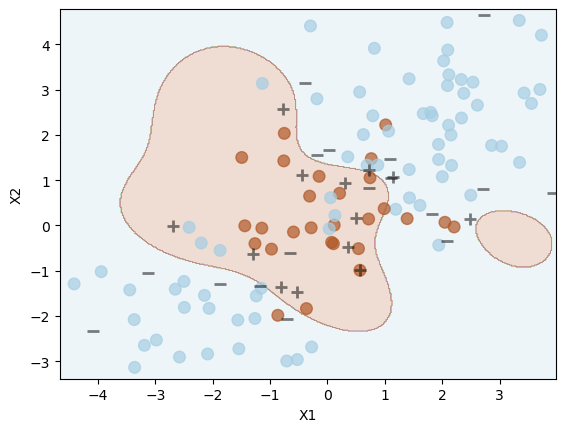

Number of support vectors:  32
Predicted  -1   1
True             
-1         66   7
 1          6  21
0.87


In [105]:
plot_svc(clf.best_estimator_, X_test, y_test)
print(make_cm(clf.best_estimator_, X_test, y_test))
print(clf.best_estimator_.score(X_test, y_test))

87% of test observations are correctly classified by this SVM. Not bad!


For the particular example we know the shape of the optimal decision. It should be strip perpendicular to the 45 degree line. Such a region can be approximated with a polynomial kernel.

In [33]:
SVC?

Init signature:
SVC(
    *,
    C=1.0,
    kernel='rbf',
    degree=3,
    gamma='scale',
    coef0=0.0,
    shrinking=True,
    probability=False,
    tol=0.001,
    cache_size=200,
    class_weight=None,
    verbose=False,
    max_iter=-1,
    decision_function_shape='ovr',
    break_ties=False,
    random_state=None,
)
Docstring:     
C-Support Vector Classification.

The implementation is based on libsvm. The fit time scales at least
quadratically with the number of samples and may be impractical
beyond tens of thousands of samples. For large datasets
consider using :class:`~sklearn.svm.LinearSVC` or
:class:`~sklearn.linear_model.SGDClassifier` instead, possibly after a
:class:`~sklearn.kernel_approximation.Nystroem` transformer.

The multiclass support is handled according to a one-vs-one scheme.

For details on the precise mathematical formulation of the provided
kernel functions and how `gamma`, `coef0` and `degree` affect each
other, see the corresponding section in the narrati

In [106]:
tuned_parameters = [
    {
        'C': [0.01, 0.1, 1, 2, 5, 10],
        'coef0': [0.5, 1, 2, 4, 8, 16]
    }
]

clf3 = GridSearchCV(
    SVC(kernel='poly', degree=2), 
    param_grid=tuned_parameters, 
    cv=10,
    refit=True,
    scoring='accuracy'
)

clf3.fit(X_train, y_train)

clf3.best_params_

{'C': 1, 'coef0': 4}

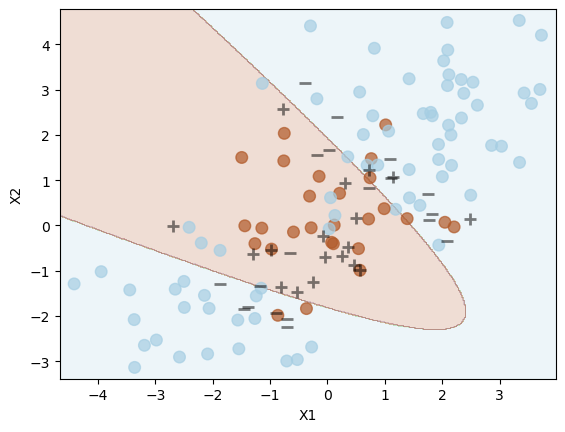

Number of support vectors:  37
Predicted  -1   1
True             
-1         65   8
 1          8  19
0.84


In [107]:
plot_svc(clf3.best_estimator_, X_test, y_test)
print(make_cm(clf3, X_test, y_test))
#print(confusion_matrix(y_test, clf.best_estimator_.predict(X_test)))
print(clf3.score(X_test, y_test))

# ROC (Reciever Operational Characteristics) Curves

The `auc()` function from the `sklearn.metrics` module can be used to produce ROC curves such as those we saw in lecture:

In [108]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

Let's start by fitting two models, one more flexible than the other:

In [109]:
# More constrained model
svm3 = SVC(C=1, kernel='rbf', gamma=1)
svm3.fit(X_train, y_train)

SVC(C=1, gamma=1)

In [110]:
# More flexible model
svm4 = SVC(C=1, kernel='rbf', gamma=50)
svm4.fit(X_train, y_train)

SVC(C=1, gamma=50)

SVMs and support vector classifiers output class labels for each observation.
However, it is also possible to obtain fitted values for each observation,
which are the numerical scores used to obtain the class labels. For instance,
in the case of a support vector classifier, the fitted value for an observation
$X = (X_1,X_2, . . .,X_p)^T$ takes the form $\hat\beta_0 + \hat\beta_1X_1 + \hat\beta_2X_2 + . . . + \hat\beta_pX_p$.

For an SVM with a non-linear kernel, the equation that yields the fitted
value is given in (9.23) on p. 352 of the ISLR book. In essence, the sign of the fitted value determines
on which side of the decision boundary the observation lies. Therefore, the
relationship between the fitted value and the class prediction for a given
observation is simple: if the fitted value exceeds zero then the observation
is assigned to one class, and if it is less than zero than it is assigned to the
other.

In order to obtain the fitted values for a given SVM model fit, we
use the `.decision_function()` method of the SVC:

In [111]:
y_train_score3 = svm3.decision_function(X_train)
y_train_score4 = svm4.decision_function(X_train)

Now we can produce the ROC plot to see how the models perform on both the training and the test data:

In [ ]:
y_train_score3 = svm3.decision_function(X_train)
y_train_score4 = svm4.decision_function(X_train)

false_pos_rate3, true_pos_rate3, _ = roc_curve(y_train, y_train_score3)
roc_auc3 = auc(false_pos_rate3, true_pos_rate3)

false_pos_rate4, true_pos_rate4, _ = roc_curve(y_train, y_train_score4)
roc_auc4 = auc(false_pos_rate4, true_pos_rate4)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,6))
ax1.plot(false_pos_rate3, 
         true_pos_rate3, 
         label='SVM $\gamma = 1$ ROC curve (area = %0.2f)' % roc_auc3, 
         color='b')

ax1.plot(false_pos_rate4, 
         true_pos_rate4, 
         label='SVM $\gamma = 50$ ROC curve (area = %0.2f)' % roc_auc4, 
         color='r')
ax1.set_title('Training Data')

y_test_score3 = svm3.decision_function(X_test)
y_test_score4 = svm4.decision_function(X_test)

false_pos_rate3, true_pos_rate3, _ = roc_curve(y_test, y_test_score3)
roc_auc3 = auc(false_pos_rate3, true_pos_rate3)

false_pos_rate4, true_pos_rate4, _ = roc_curve(y_test, y_test_score4)
roc_auc4 = auc(false_pos_rate4, true_pos_rate4)

ax2.plot(false_pos_rate3, 
         true_pos_rate3, 
         label='SVM $\gamma = 1$ ROC curve (area = %0.2f)' % roc_auc3, 
         color='b')
ax2.plot(false_pos_rate4, 
         true_pos_rate4, 
         label='SVM $\gamma = 50$ ROC curve (area = %0.2f)' % roc_auc4, 
         color='r')
ax2.set_title('Test Data')

for ax in fig.axes:
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

But it is much easier to use the function provided by `sklearn`

In [112]:
from sklearn.metrics import RocCurveDisplay

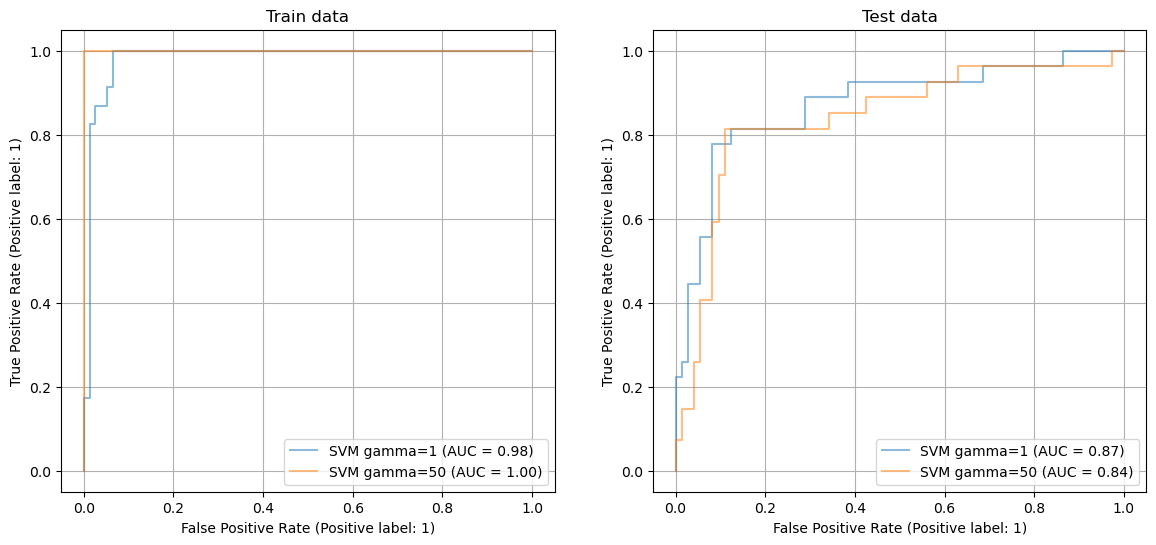

In [136]:
fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(14, 6))

for svm_ in [svm3, svm4]:
    RocCurveDisplay.from_estimator(
        svm_,
        X=X_train,
        y=y_train,
        name=f'SVM gamma={svm_.gamma}',
        alpha=0.5,
        ax = ax1
    )
ax1.set_title('Train data')
ax1.grid()

for svm_ in [svm3, svm4]:
    RocCurveDisplay.from_estimator(
        svm_,
        X=X_test,
        y=y_test,
        name=f'SVM gamma={svm_.gamma}',
        alpha=0.5,
        ax = ax2
    )
ax2.set_title('Test data')
ax2.grid()


# SVM with Multiple Classes

If the response is a factor containing more than two levels, then the `SVC()`
estimator will perform multi-class classification using the one-versus-one approach.
We explore that setting here by generating a third class of observations:

Text(0, 0.5, 'XX2')

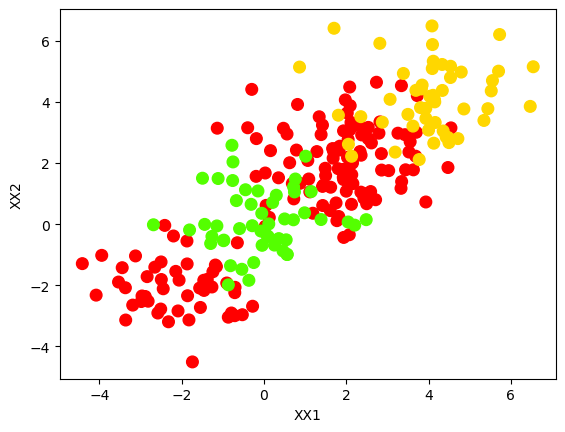

In [137]:
np.random.seed(8)
XX = np.vstack([X, np.random.randn(50,2)])
yy = np.hstack([y, np.repeat(0,50)])
XX[yy ==0] = XX[yy == 0] +4

plt.scatter(XX[:,0], XX[:,1], s=70, c=yy, cmap=plt.cm.prism)
plt.xlabel('XX1')
plt.ylabel('XX2')

Fitting an SVM to multiclass data uses identical syntax to fitting a simple two-class model:

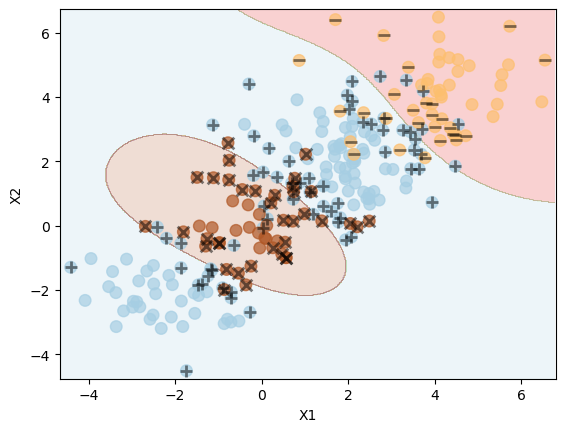

Number of support vectors:  128


In [151]:
svm5 = SVC(C=1, kernel='rbf')
svm5.fit(XX, yy)
plot_svc(svm5, XX, yy)

# Application to Handwritten Letter Data

We now examine [`Optical Recognition of Handwritten Digits Data Set`](http://archive.ics.uci.edu/ml/datasets/optical+recognition+of+handwritten+digits), which contains 5,620 samples of handwritten digits 0...9. You can use these links to download the [training data](http://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tra) and [test data](http://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tes), and then we'll load them into python:

In [ ]:
#!wget http://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tra
#!wget http://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tes

In [408]:
X_train = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tra',
                       header=None)
X_test = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tes',
                       header=None)

In [409]:
print(f'train data shape: {X_train.shape}, test data shape: {X_test.shape}')

train data shape: (3823, 65), test data shape: (1797, 65)


In [410]:
X_train.describe()


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
count,3823.0,3823.000000,3823.000000,3823.000000,3823.000000,3823.000000,3823.000000,3823.000000,3823.000000,3823.000000,...,3823.000000,3823.000000,3823.000000,3823.000000,3823.000000,3823.000000,3823.000000,3823.000000,3823.000000,3823.000000
mean,0.0,0.301334,5.481821,11.805912,11.451478,5.505362,1.387392,0.142297,0.002093,1.960502,...,0.148313,0.000262,0.283024,5.855872,11.942977,11.461156,6.700497,2.105676,0.202197,4.497253
std,0.0,0.866986,4.631601,4.259811,4.537556,5.613060,3.371444,1.051598,0.088572,3.052353,...,0.767761,0.016173,0.928046,4.980012,4.334508,4.991934,5.775815,4.028266,1.150694,2.869831
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,10.000000,9.000000,0.000000,0.000000,0.000000,2.000000
50%,0.0,0.000000,5.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,5.000000,13.000000,13.000000,6.000000,0.000000,0.000000,4.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,10.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,10.000000,15.000000,16.000000,12.000000,2.000000,0.000000,7.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,5.000000,15.000000,...,12.000000,1.000000,10.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,9.000000


In [411]:

X_train.head()


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,0,1,6,15,12,1,0,0,0,7,...,0,0,0,6,14,7,1,0,0,0
1,0,0,10,16,6,0,0,0,0,7,...,0,0,0,10,16,15,3,0,0,0
2,0,0,8,15,16,13,0,0,0,1,...,0,0,0,9,14,0,0,0,0,7
3,0,0,0,3,11,16,0,0,0,0,...,0,0,0,0,1,15,2,0,0,4
4,0,0,5,14,4,0,0,0,0,0,...,0,0,0,4,12,14,7,0,0,6


In [412]:
# X_train = pd.read_csv('optdigits.tra', header=None)
y_train = X_train[64]
X_train = X_train.drop(X_train.columns[64], axis=1)

# X_test = pd.read_csv('optdigits.tes', header=None)
y_test = X_test[64]
X_test = X_test.drop(X_test.columns[64], axis=1)

Let's take a look at the dimensions of this dataset:

In [413]:
print(X_train.shape)
print(X_test.shape)

(3823, 64)
(1797, 64)


This data set consists of preprocessed images of handwriting samples gathered from 43 different people. Each image was converted into an 8x8 matrix (64 pixels), which was then flattened into a vector of 64 numeric values. The final column contains the class label for each digit.

The training and test sets consist of 3,823 and 1,797 observations respectively. Let's see what one of these digits looks like:

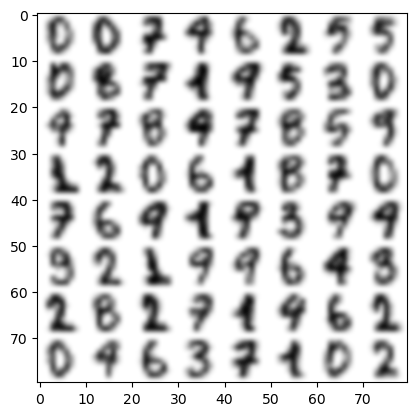

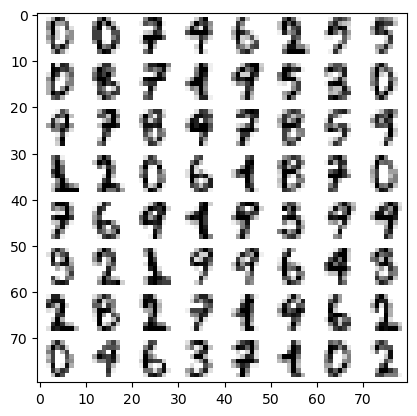

In [414]:
sample_img = np.zeros((8*10,8*10), dtype=np.uint8)

for k in range(64):
    i,j = divmod(k, 8)
    sample_img[1+i*10:1+i*10+8, 1+j*10:1+j*10+8] = X_train.loc(0)[k].values.reshape(8, 8)
plt.imshow(sample_img, cmap="gray_r", vmin=0, vmax=16, interpolation='bicubic') 
plt.show()

plt.imshow(sample_img, cmap="gray_r", vmin=0, vmax=16, interpolation='none') 
plt.show()


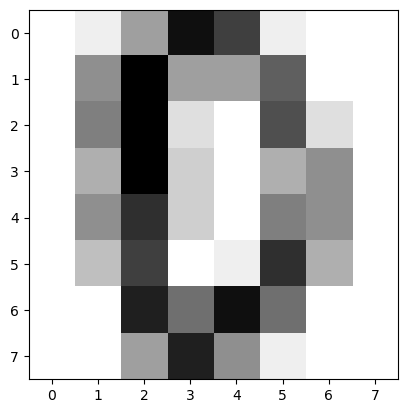

In [415]:
plt.imshow(X_train.values[0].reshape(8,8), cmap='gray_r', vmin=0, vmax=16, interpolation='nearest')

That's a pretty messy digit. Let's peek at the true class:

In [416]:
y_train[0]

0

Phew, looks like our SVM has its work cut out for it! Let's start with a linear kernel to see how we do:

In [417]:
svc = SVC(kernel='linear', C=1)
svc.fit(X_train, y_train)

# Print a nice confusion matrix
make_cm(svc, X_train, y_train)

Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,376,0,0,0,0,0,0,0,0,0
1,0,389,0,0,0,0,0,0,0,0
2,0,0,380,0,0,0,0,0,0,0
3,0,0,0,389,0,0,0,0,0,0
4,0,0,0,0,387,0,0,0,0,0
5,0,0,0,0,0,376,0,0,0,0
6,0,0,0,0,0,0,377,0,0,0
7,0,0,0,0,0,0,0,387,0,0
8,0,0,0,0,0,0,0,0,380,0


We see that there are **no training errors**. In fact, this is not surprising,
because the large number of variables relative to the number of observations
implies that it is easy to find hyperplanes that fully separate the classes. We
are most interested not in the support vector classifier’s performance on the
training observations, but rather its performance on the test observations:

In [418]:
cm = make_cm(svc, X_test, y_test)
cm

Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,177,0,0,0,0,1,0,0,0,0
1,0,178,0,0,0,0,3,0,1,0
2,0,7,170,0,0,0,0,0,0,0
3,1,0,5,171,0,2,0,2,1,1
4,0,0,0,0,180,0,0,0,1,0
5,0,0,1,0,0,180,0,0,0,1
6,0,0,0,0,1,0,179,0,1,0
7,0,0,0,0,1,7,0,165,0,6
8,0,9,1,5,0,2,0,0,157,0


In [193]:
off_diag_sum = cm.values.sum() - sum(cm.values[i,i] for i in range(10))
print(f'number of errors on test data: {off_diag_sum}')
svc.get_params()

number of errors on test data: 70


{'C': 1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

We see that using `cost = 1` yields just 70 test set errors on this data. Now try using the `GridSearchCV()` function to select an optimal value for `C`. Consider values in the range 0.01 to 100:

In [422]:
digits_svc = GridSearchCV(
    SVC(kernel='linear'), 
    param_grid={
        'C': [1e-5, 1e-4, 0.001, 0.01, 0.1, 1, 10, 100]
    }, 
    cv=10, 
    refit=True
)
digits_svc.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SVC(kernel='linear'),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]})

In [423]:
digits_svc.cv_results_

{'mean_fit_time': array([0.39707735, 0.12295511, 0.0594382 , 0.06200233, 0.06596675,
        0.06402645, 0.06392388, 0.06414587]),
 'std_fit_time': array([0.00930931, 0.00207552, 0.00086084, 0.00187365, 0.00491606,
        0.00178281, 0.00186029, 0.00183267]),
 'mean_score_time': array([0.03580325, 0.02076006, 0.01004195, 0.00719986, 0.007002  ,
        0.0068732 , 0.00685797, 0.00692875]),
 'std_score_time': array([0.00067008, 0.00174407, 0.00012172, 0.00018985, 0.00027943,
        0.00013892, 0.00018283, 0.00018507]),
 'param_C': masked_array(data=[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1e-05},
  {'C': 0.0001},
  {'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 10},
  {'C': 100}],
 'split0_test_score': array([0.92167102, 0.94778068, 0.96344648, 0.97389034, 0.97127937,
        0.97127937, 0.97127937, 0.97127937]),
 'spl

In [424]:
digits_svc.best_params_

{'C': 0.001}

In [434]:
best_model = digits_svc.best_estimator_
print(f'Number of support vectors {best_model.n_support_}')


Number of support vectors [ 41 113  76  95  85 102  65  79 121 132]


In [435]:
make_cm(best_model, X_train, y_train)

Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,376,0,0,0,0,0,0,0,0,0
1,0,389,0,0,0,0,0,0,0,0
2,0,0,380,0,0,0,0,0,0,0
3,0,0,0,389,0,0,0,0,0,0
4,0,0,0,0,387,0,0,0,0,0
5,0,0,0,0,0,376,0,0,0,0
6,0,0,0,0,0,0,377,0,0,0
7,0,0,0,0,0,0,0,387,0,0
8,0,1,0,0,0,0,0,0,379,0


In [436]:
make_cm(best_model, X_test, y_test)

Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,178,0,0,0,0,0,0,0,0,0
1,0,181,0,0,0,0,0,0,1,0
2,0,1,175,0,0,0,0,0,1,0
3,0,0,0,178,0,2,0,1,2,0
4,0,0,0,0,180,0,0,0,1,0
5,0,0,0,0,0,181,0,0,0,1
6,1,0,0,0,0,0,180,0,0,0
7,0,0,0,0,0,5,0,167,0,7
8,0,5,0,1,0,1,0,0,165,2


In [427]:
from sklearn.metrics import classification_report, make_scorer

In [437]:
print(make_scorer(classification_report)(best_model, X_test, y_test))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       178
           1       0.97      0.99      0.98       182
           2       1.00      0.99      0.99       177
           3       0.98      0.97      0.98       183
           4       1.00      0.99      1.00       181
           5       0.95      0.99      0.97       182
           6       1.00      0.99      1.00       181
           7       0.99      0.93      0.96       179
           8       0.96      0.95      0.96       174
           9       0.95      0.97      0.96       180

    accuracy                           0.98      1797
   macro avg       0.98      0.98      0.98      1797
weighted avg       0.98      0.98      0.98      1797



# Radial basis kernel

In [467]:
%%time
digits_svc = GridSearchCV(
    SVC(kernel='rbf'), 
    param_grid={
        'C': [0.01, 0.1, 1, 10, 100]
    }, 
    cv=5, 
    refit=True
)
digits_svc.fit(X_train, y_train)

CPU times: user 7.6 s, sys: 527 µs, total: 7.6 s
Wall time: 7.6 s


GridSearchCV(cv=5, estimator=SVC(), param_grid={'C': [0.01, 0.1, 1, 10, 100]})

In [430]:
digits_svc.best_estimator_.C

10

In [468]:
best_model = digits_svc.best_estimator_
print(make_scorer(classification_report)(best_model, X_test, y_test))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       178
           1       0.97      0.99      0.98       182
           2       1.00      0.99      0.99       177
           3       0.98      0.97      0.98       183
           4       1.00      0.99      1.00       181
           5       0.95      0.99      0.97       182
           6       1.00      0.99      1.00       181
           7       0.99      0.93      0.96       179
           8       0.96      0.95      0.96       174
           9       0.95      0.97      0.96       180

    accuracy                           0.98      1797
   macro avg       0.98      0.98      0.98      1797
weighted avg       0.98      0.98      0.98      1797



In [469]:
print(f'Number of support vectors {best_model.n_support_}, total: {sum(best_model.n_support_)}')
print('Train data')
print(make_cm(best_model, X_train, y_train))
print('-'*20)
print('Test data')
print(make_cm(best_model, X_test, y_test))

Number of support vectors [ 41 113  76  95  85 102  65  79 121 132], total: 909
Train data
Predicted    0    1    2    3    4    5    6    7    8    9
True                                                       
0          376    0    0    0    0    0    0    0    0    0
1            0  389    0    0    0    0    0    0    0    0
2            0    0  380    0    0    0    0    0    0    0
3            0    0    0  389    0    0    0    0    0    0
4            0    0    0    0  387    0    0    0    0    0
5            0    0    0    0    0  376    0    0    0    0
6            0    0    0    0    0    0  377    0    0    0
7            0    0    0    0    0    0    0  387    0    0
8            0    1    0    0    0    0    0    0  379    0
9            0    0    0    0    0    0    0    0    0  382
--------------------
Test data
Predicted    0    1    2    3    4    5    6    7    8    9
True                                                       
0          178    0    0    0    0    

In [441]:
digits_svc = GridSearchCV(
    SVC(kernel='rbf'), 
    param_grid={
        'C': [10], 
        'gamma': [0.5, 1, 2]
    }, 
    cv=5, 
    refit=True
)
digits_svc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [10], 'gamma': [0.5, 1, 2]})

In [442]:
digits_svc.best_params_

{'C': 10, 'gamma': 2}

In [443]:
best_model = digits_svc.best_estimator_
print(make_scorer(classification_report)(digits_svc.best_estimator_, X_test, y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       178
           1       0.00      0.00      0.00       182
           2       0.00      0.00      0.00       177
           3       0.10      1.00      0.18       183
           4       0.00      0.00      0.00       181
           5       0.00      0.00      0.00       182
           6       0.00      0.00      0.00       181
           7       0.00      0.00      0.00       179
           8       0.00      0.00      0.00       174
           9       0.00      0.00      0.00       180

    accuracy                           0.10      1797
   macro avg       0.01      0.10      0.02      1797
weighted avg       0.01      0.10      0.02      1797



/home/prokaj/.config/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/prokaj/.config/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/prokaj/.config/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [445]:
print(f'Number of support vectors {best_model.n_support_}')
print('Train data')
print(make_cm(digits_svc.best_estimator_, X_train, y_train))
print('-'*20)
print('Test data')
print(make_cm(digits_svc.best_estimator_, X_test, y_test))

Number of support vectors [376 389 380 389 387 376 377 387 380 382]
Train data
Predicted    0    1    2    3    4    5    6    7    8    9
True                                                       
0          376    0    0    0    0    0    0    0    0    0
1            0  389    0    0    0    0    0    0    0    0
2            0    0  380    0    0    0    0    0    0    0
3            0    0    0  389    0    0    0    0    0    0
4            0    0    0    0  387    0    0    0    0    0
5            0    0    0    0    0  376    0    0    0    0
6            0    0    0    0    0    0  377    0    0    0
7            0    0    0    0    0    0    0  387    0    0
8            0    0    0    0    0    0    0    0  380    0
9            0    0    0    0    0    0    0    0    0  382
--------------------
Test data
Predicted  0  1  2    3  4  5  6  7  8  9
True                                     
0          0  0  0  178  0  0  0  0  0  0
1          0  0  0  182  0  0  0  0  0  0
2 

## What went wrong? 

We did not scale the features!

The kernel
$$
K(x,x') = \exp\{-\gamma\|x-x'\|^2\}
$$
Here $x-x'$ is a vector of size 64 with values in $-16,16$, so $\|x-x'\|^2$ is typically large. 

A small sample of the kernel matrix

In [446]:
X = X_train.values
print(f'X shape: {X.shape}, dtype: {X.dtype}')
x = X[np.random.choice(len(X), 10, False)]

gamma = 0.1
K = np.exp(-gamma*((x[:,None] - x)**2).sum(axis=-1))
K.round(5)


X shape: (3823, 64), dtype: int64


array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

When $K$ is the identity matrix the dual problem becomes
$$
    \arg\max_{\alpha} \sum_{i} \alpha_i -\frac12\sum \alpha_i\alpha_j y_iy_j K(x_i, x_j),
    \quad 
    \text{s.t.} 
    \quad
    \alpha_{i}\in [0,C], \quad\sum_{i} \alpha_iy_i=0
$$
When $K$ is the identity matrix, it simplifies to
$$
    \arg\max_{\alpha} \sum_{i} \alpha_i -\frac12\alpha_i^2=\arg\max -\frac12\sum_i(\alpha_i-1)^2,
    \quad 
    \text{s.t.} 
    \quad
    \alpha_{i}\in [0,C], \quad\sum_{i} \alpha_iy_i=0
$$
If $C$ is large enough then each vectors are support vectors and $\alpha =\mathbb{1}-\bar{y}y$. 
Then the predictions are 
$$
    \operatorname{sign}(\sum_i y_i\alpha_i K(x_i, x) + \beta_0)
$$
Here again $K(x_i, x)$ is approximately zero and the decision is based on the intercept term $\beta_0$.

In [448]:
#digits_svc.best_estimator_.dual_coef_.shape, digits_svc.best_estimator_.n_support_, digits_svc.best_estimator_.intercept_.shape

In [449]:
#SVC?

When the `gamma` parameter is not specified the next rule is used!

In [453]:
gamma_0 = 1/(X_train.values.var()*len(X_train.columns))
gamma_0

0.00042879695253758224

In [455]:
%%time
digits_svc2 = GridSearchCV(
    SVC(kernel='rbf'), 
    param_grid={
        'C': [2.5, 5, 7],
        'gamma': [c*gamma_0 for c in [0.25, 0.5, 1, 1.25, 1.5, 2]]
    }, 
    cv=5, 
    refit=True
)
digits_svc2.fit(X_train, y_train)

CPU times: user 11.4 s, sys: 753 µs, total: 11.4 s
Wall time: 11.4 s


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [2.5, 5, 7],
                         'gamma': [0.00010719923813439556,
                                   0.00021439847626879112,
                                   0.00042879695253758224,
                                   0.0005359961906719778, 0.0006431954288063734,
                                   0.0008575939050751645]})

In [457]:
best_model = digits_svc2.best_estimator_

best_model.C, best_model.gamma, gamma_0 

(5, 0.0008575939050751645, 0.00042879695253758224)

In [458]:
print(make_scorer(classification_report)(best_model, X_test, y_test))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       178
           1       0.96      0.99      0.98       182
           2       1.00      0.98      0.99       177
           3       0.98      0.98      0.98       183
           4       1.00      1.00      1.00       181
           5       0.97      0.99      0.98       182
           6       1.00      0.99      1.00       181
           7       0.99      0.95      0.97       179
           8       0.98      0.96      0.97       174
           9       0.95      0.98      0.96       180

    accuracy                           0.98      1797
   macro avg       0.98      0.98      0.98      1797
weighted avg       0.98      0.98      0.98      1797



In [459]:
print(f'Number of support vectors {sum(best_model.n_support_)}')
print('Train data')
print(make_cm(best_model, X_train, y_train))
print('-'*20)
print('Test data')
print(make_cm(best_model, X_test, y_test))

Number of support vectors 1136
Train data
Predicted    0    1    2    3    4    5    6    7    8    9
True                                                       
0          376    0    0    0    0    0    0    0    0    0
1            0  389    0    0    0    0    0    0    0    0
2            0    0  380    0    0    0    0    0    0    0
3            0    0    0  389    0    0    0    0    0    0
4            0    0    0    0  387    0    0    0    0    0
5            0    0    0    0    0  376    0    0    0    0
6            0    0    0    0    0    0  377    0    0    0
7            0    0    0    0    0    0    0  387    0    0
8            0    1    0    0    0    0    0    0  379    0
9            0    0    0    0    0    0    0    0    0  382
--------------------
Test data
Predicted    0    1    2    3    4    5    6    7    8    9
True                                                       
0          178    0    0    0    0    0    0    0    0    0
1            0  181    0   

## Polynomial kernel   

In [460]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [463]:
%%time
digits_svc2 = GridSearchCV(
    SVC(kernel='poly'), 
    param_grid={
        'C': [0.125, 0.25, 0.5],
        'coef0': [0.05, .1, 0.2],
        'degree': [3, 4, 5]
    }, 
    cv=5, 
    refit=True
)
scaler = MinMaxScaler()
scaler.fit(X_train)
digits_svc2.fit(scaler.transform(X_train), y_train)

CPU times: user 10.9 s, sys: 9.3 ms, total: 10.9 s
Wall time: 11 s


GridSearchCV(cv=5, estimator=SVC(kernel='poly'),
             param_grid={'C': [0.125, 0.25, 0.5], 'coef0': [0.05, 0.1, 0.2],
                         'degree': [3, 4, 5]})

In [464]:
best_model = digits_svc2.best_estimator_

best_model.C, best_model.coef0, best_model.degree

(0.25, 0.1, 4)

In [465]:
print(make_scorer(classification_report)(best_model, scaler.transform(X_test), y_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       178
           1       0.97      0.99      0.98       182
           2       0.99      0.99      0.99       177
           3       0.98      0.96      0.97       183
           4       0.99      1.00      1.00       181
           5       0.96      0.99      0.98       182
           6       1.00      0.99      1.00       181
           7       0.99      0.95      0.97       179
           8       0.98      0.94      0.96       174
           9       0.92      0.97      0.94       180

    accuracy                           0.98      1797
   macro avg       0.98      0.98      0.98      1797
weighted avg       0.98      0.98      0.98      1797



In [466]:
print(f'Number of support vectors {sum(best_model.n_support_)}')
print('Train data')
print(make_cm(best_model, scaler.transform(X_train), y_train))
print('-'*20)
print('Test data')
print(make_cm(best_model, scaler.transform(X_test), y_test))

Number of support vectors 819
Train data
Predicted    0    1    2    3    4    5    6    7    8    9
True                                                       
0          375    0    0    0    1    0    0    0    0    0
1            0  388    0    0    0    0    0    0    0    1
2            0    0  380    0    0    0    0    0    0    0
3            0    0    0  388    0    1    0    0    0    0
4            0    0    0    0  385    0    1    0    0    1
5            0    0    0    0    0  376    0    0    0    0
6            0    1    0    0    0    0  376    0    0    0
7            0    0    0    0    0    0    0  387    0    0
8            0    1    0    0    0    0    0    0  379    0
9            0    0    0    0    1    0    0    0    0  381
--------------------
Test data
Predicted    0    1    2    3    4    5    6    7    8    9
True                                                       
0          177    0    0    0    1    0    0    0    0    0
1            0  180    0    